In [24]:
import csv
import os
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import functions

In [2]:
def get_aqi_data():
    
    '''This function gets all the aqi data from https://aqicn.org for several cities.
    It returns a dictionary with all the dataframes and creates csv files for all of them in
    the current folder'''

    CSV_URLS = 'https://aqicn.org/data-platform/covid19/report/22408-10ad85dd/'
    time_periods = ['2021Q1','2020Q1', '2020Q2', '2020Q3', '2020Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2018H1', '2017H1', '2016H1', 
                '2015H1']

    dic = {}
    for period in time_periods:
    
        response = requests.get(CSV_URLS + period)
        string_data = response.content.decode('utf-8')
        list_data = [row.split(',') for row in string_data.split('\n')]
        # Remove header
        del list_data[:4]
    
        columns = list_data[0]
        values = list_data[1:]
    
        dic[period] = pd.DataFrame(values, columns=columns)
        
    for name, df in dic.items():
    df.to_csv('./'+name+'.csv')
    
    return dic



In [3]:
#Save data to csv files
for name, df in dic.items():
    df.to_csv('./'+name+'.csv')

In [7]:
ls

 Volume in drive C is OS
 Volume Serial Number is 3676-8483

 Directory of C:\Users\Pablo Vales\Documents\Data Science\Projects

25-Mar-21  09:05 PM    <DIR>          .
25-Mar-21  09:05 PM    <DIR>          ..
21-Mar-21  09:43 PM    <DIR>          .ipynb_checkpoints
25-Mar-21  08:58 PM        22,773,869 2015H1.csv
25-Mar-21  08:58 PM        24,208,329 2016H1.csv
25-Mar-21  08:58 PM        25,093,891 2017H1.csv
25-Mar-21  08:58 PM        33,126,568 2018H1.csv
25-Mar-21  08:58 PM        30,305,502 2019Q1.csv
25-Mar-21  08:58 PM        32,293,693 2019Q2.csv
25-Mar-21  08:58 PM        36,110,781 2019Q3.csv
25-Mar-21  08:58 PM        35,770,454 2019Q4.csv
25-Mar-21  08:57 PM        33,265,924 2020Q1.csv
25-Mar-21  08:57 PM        37,345,923 2020Q2.csv
25-Mar-21  08:58 PM        37,049,039 2020Q3.csv
25-Mar-21  08:58 PM        36,327,646 2020Q4.csv
25-Mar-21  09:03 PM        28,689,068 2021Q1.csv
25-Mar-21  09:05 PM            19,694 Untitled.ipynb
              14 File(s)    412,380,381 byt

# Business case

Air pollution is one the main risk factors to develop diseases. Has Covid benefitted us in this regard?

# Data cleaning

## Grouping of files and concatenation of DataFrames

In [3]:
def concatenate_per_year(year):
    '''Helper function: Puts together the csv files for a single year in one DataFrame
    INPUT: int year to group
    OUTPUT: pd.DataFrame'''
    files_in_folder = [file for file in os.listdir() if os.path.isfile(os.path.join(os.getcwd(),file))]
                                  
    df = pd.DataFrame()
    for file in files_in_folder:
        if re.search('^{}'.format(str(year)), string=file):
            temp_df = pd.read_csv(file)
            df = pd.concat([df, temp_df])
    return df

def concatenate_all_years(years):
    '''Creates a single dataframe with the data across all years contained in years
    INPUT: list of ints years to concatenate
    OUTPUT: pd.DataFrame with the data for all years'''
    df = pd.DataFrame()
    for year in years:
            df = pd.concat([df, concatenate_per_year(year)])
    return df
        
            

df15 = concatenate_per_year(2015)
df16 = concatenate_per_year(2016)
df17 = concatenate_per_year(2017)
df18 = concatenate_per_year(2018)
df19 = concatenate_per_year(2019)
df20 = concatenate_per_year(2020)
df21 = concatenate_per_year(2021)

In [4]:
df = concatenate_all_years([2015,2016,2017,2018,2019,2020,2021])
df.head()

,Unnamed: 0,Date,Country,City,Specie,count,min,max,median,variance
0,0.0,2015-01-06,KR,Jeonju,co,124.0,0.1,12.3,4.5,55.74
1,1.0,2015-01-22,KR,Jeonju,co,116.0,4.5,10.0,6.7,16.09
2,2.0,2015-03-30,KR,Jeonju,co,118.0,1.2,11.2,5.6,35.98
3,3.0,2015-05-27,KR,Jeonju,co,93.0,2.3,5.6,3.4,6.54
4,4.0,2015-02-03,KR,Jeonju,co,133.0,4.5,13.4,7.8,39.24


In [5]:
df = df.reset_index().drop(['index', 'Unnamed: 0'], axis=1)

In [6]:
df.shape

(6814872, 9)

First of all lets get rid of the data that we are not interested in. This dataframe has information for several markers, which are:

In [7]:
df.Specie.unique()

array(['co', 'pm10', 'o3', 'so2', 'no2', 'pm25', 'psi', 'uvi', 'neph',
       'aqi', 'mepaqi', nan, 'pol', 'temperature', 'humidity', 'pressure',
       'wd', 'wind-speed', 'd', 'pm1', 'wind-gust', 'precipitation',
       'dew', 'wind speed', 'wind gust'], dtype=object)

Although all of the atmospheric parameters in this table can affect the air contamination (specially wind and precipitations), we will be looking at a span of several years, so we will solely focus on the pollutant amount. It is safe to assume the meteorological parameters where approximately the same for the same time periods throughout our 5 year span.

In [8]:
pollutants = ['co', 'pm10', 'o3', 'so2', 'no2', 'pm25', 'pm1']
df_whole = df.copy(deep=True)
df = df[df.Specie.isin(pollutants)]

In [9]:
df.Specie.unique(), df.shape

(array(['co', 'pm10', 'o3', 'so2', 'no2', 'pm25', 'pm1'], dtype=object),
 (3943636, 9))

Now we have all data (almost 4 million points) from 2015-2021 in one DataFrame corresponding to the different air pollutants.

Do we have missing values?:


In [10]:
df.isna().sum()

Date        0
Country     0
City        0
Specie      0
count       0
min         0
max         0
median      0
variance    0
dtype: int64

Let's check now what datatypes we have in our table:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943636 entries, 0 to 6814705
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Date      object 
 1   Country   object 
 2   City      object 
 3   Specie    object 
 4   count     float64
 5   min       float64
 6   max       float64
 7   median    float64
 8   variance  float64
dtypes: float64(5), object(4)
memory usage: 300.9+ MB


Everything looks good except the date, which we want to parse to obtain a datetime type

In [12]:
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943636 entries, 0 to 6814705
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Date      datetime64[ns]
 1   Country   object        
 2   City      object        
 3   Specie    object        
 4   count     float64       
 5   min       float64       
 6   max       float64       
 7   median    float64       
 8   variance  float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 300.9+ MB


In [14]:
countries = ['ES', 'IT', 'US', 'IN', 'FR', 'SK', 'DE', 'CN', 'AU']

Let's make a function to calculate the monthly mean AQI values for cities and countries

In [123]:
def monthly_city_pollutant(df):
    print('Calculating the the AQI for each pollutant, month and city')
    final_df = pd.DataFrame()
   
    pollutants = df.Specie.unique()
    for pollutant in pollutants:
        pollutant_df = df[df.Specie == pollutant]
        countries = pollutant_df.Country.unique()
        for country in countries:
            country_df = pollutant_df[pollutant_df.Country == country]
            cities_country = country_df.City.unique()
            for city in cities_country:
                city_df = country_df[country_df.City == city]
                years = city_df.Date.dt.year.unique()
                for year in years:
                    year_df = city_df[city_df.Date.dt.year == year]
                    months = year_df.Date.dt.month.unique()
                    for month in months:
                        #Dataframe with a particular city in a given country
                        month_df = year_df[year_df.Date.dt.month == month]
                            
                        mean_ser = month_df['median']
                        date_string = '{}/{}'.format(year, month)
                            
                        #Standard deviation
                        std_dev = np.std(month_df['median'])
                        no_days_per_month = month_df.Date.count()
                            
                        std_dev_mean = std_dev/np.sqrt(no_days_per_month)
                            
                        ## T-test confidence interval
                        alpha= 0.95
                        error_95th = stats.t.interval(df=no_days_per_month-1, alpha=alpha)[1] * std_dev_mean
                        # Note: months that only have one measurement will be given a NaN value by the t-test and thus, won't be taken into account further
                            
                            
                            
                        temp_df = pd.DataFrame(data={'Date':datetime.strptime(date_string, '%Y/%m'), 'Country': country, 'City': city, 'Specie': pollutant, 'No_points': no_days_per_month, \
                                                         'AQI': [mean_ser.mean()], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
                        #print(temp_df)
                        final_df = pd.concat([final_df, temp_df])
                        
                        
                           
    return final_df.reset_index().drop('index', axis=1)
    

In [78]:
%%time
month_city_pollut_df = monthly_city_pollutant(df)

Wall time: 11min 31s


In [84]:
month_city_pollut_df.isna().sum()

Date                    0
Country                 0
City                    0
Specie                  0
No_points               0
AQI                     0
std_dev                 0
conf_interval_95%    5555
dtype: int64

In [80]:
month_city_pollut_df.Country.unique()

array(['KR', 'NL', 'CY', 'IL', 'BE', 'LT', 'PE', 'PL', 'RS', 'MN', 'MX',
       'SG', 'DE', 'DK', 'SK', 'TW', 'AU', 'CO', 'EC', 'ES', 'FI', 'US',
       'AE', 'FR', 'JP', 'TR', 'VN', 'IN', 'CL', 'MO', 'IR', 'IT', 'HU',
       'TH', 'BG', 'HK', 'AR', 'NO', 'BR', 'CA', 'CN', 'GB', 'RU', 'HR',
       'RE', 'AT', 'MK', 'GT', 'NZ', 'BA', 'PH', 'SA', 'IS', 'ZA', 'JO',
       'GR', 'GE', 'XK', 'KZ', 'KW', 'SE', 'RO', 'CH', 'BO', 'CZ', 'PT',
       'ID', 'NP', 'EE', 'IE', 'UA', 'LA', 'MM', 'SV', 'BD', 'ET', 'UG',
       'BH', 'LK', 'UZ', 'KG', 'CW', 'PR', 'IQ', 'PK', 'TJ', 'DZ', 'TM',
       'AF', 'ML', 'CR', 'GN', 'CI', 'GH'], dtype=object)

In [124]:
def monthly_country_pollutant(df):
    '''This function calculates the monthly aqi average of all the pollutants present in the table for the inserted countries and for all the available years in the dataset.
    It also corrects the median values which are larger than 500 (following the US EPA standard, which ranges from 0-500)
    INPUT: df: pd.DataFrame with columns 'Date', 'Country', 'City', 'median'
            countries: list with the countries to be extracted
            cities: bool if False the output is a pd.DataFrame with the COUNTRY average AQI values per month. If True, the output is a pd.DataFrame with the CITIES AQI average per month
    OUTPUT: '''
    print('Calculating the the AQI for each pollutant, month and country')
    if 'AQI' in df.columns: #already treated dataframe with city means. See monthly_city_pollutant function
        print('Logical')
        city_df = df
        final_df = pd.DataFrame()
        years = np.sort(city_df.Date.dt.year.unique())
        for year in years:
            year_df = city_df[city_df.Date.dt.year == year]
            months = year_df.Date.dt.month.unique()
            for month in months:
                month_df = year_df[year_df.Date.dt.month == month]
                countries = month_df.Country.unique()
                for country in countries:
                    country_df = month_df[month_df.Country == country]
                    pollutants = country_df.Specie.unique()

                    # Calculation of the yearly mean for each pollutant:
                    for pollutant in pollutants:
                        pollutant_df = country_df[country_df.Specie == pollutant]

                        # Yearly mean of the AQI for a particular pollutant and country
                        mean_yearly_pollutant = pollutant_df['AQI'].mean() 

                        # Standard deviation of the mean yearly pollutant. Assuming i.i.d i.e Cov = 0
                        std_dev_mean = np.sqrt((pollutant_df.std_dev ** 2).sum())/pollutant_df.shape[0] # Propagation of std. deviations for the mean
                        no_points = pollutant_df.shape[0]

                        total_no_points = pollutant_df.No_points.sum()
                        #T-test confidence interval calculation
                        alpha= 0.95
                        error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean

                        # Calculation of the overall AQI (max of the individual pollutant AQIs)

                        date_string = '{}'.format(year)
                        temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), 'Country': country, 'Total_no_points': total_no_points, \
                                                    'No_points': no_points, 'Pollutant': pollutant, 'AQI': [mean_yearly_pollutant], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
                        final_df = pd.concat([final_df, temp_df])    
        
        
    else: # raw data. We take each country as a single population, not as a region composed of individual cities.
        print('Not_logical')
        final_df = pd.DataFrame()
        pollutants = df.Specie.unique()
        for pollutant in pollutants:
            pollutant_df = df[df.Specie == pollutant]
            countries = pollutant_df.Country.unique()
            for country in countries:
                country_df = pollutant_df[pollutant_df.Country == country]
                years = country_df.Date.dt.year.unique()
                for year in years:
                    year_df = country_df[country_df.Date.dt.year == year]
                    months = year_df.Date.dt.month.unique()
                    for month in months:
                        #Dataframe with all cities for a given country
                        month_country_df = year_df[year_df.Date.dt.month == month]

                        mean_ser = month_country_df['median'] 
                        date_string = '{}/{}'.format(year, month)

                        #Standard deviation
                        std_dev = np.std(month_country_df['median'])
                        no_points = month_country_df.shape[0]

                        std_dev_mean = std_dev/np.sqrt(no_points)

                        ## T-test confidence interval
                        alpha= 0.95
                        error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
                        # Note: months that only have one measurement will be given a NaN value by the t-test and thus, won't be taken into account further

                        temp_df = pd.DataFrame(data={'Date':datetime.strptime(date_string, '%Y/%m'), 'Country': country, 'No_points': no_points, 'Specie': pollutant, \
                                                         'AQI': [mean_ser.mean()], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})

                        #print(temp_df)
                        final_df = pd.concat([final_df, temp_df])


                

                        
                           
    return final_df.reset_index().drop('index', axis=1)

In [93]:
d = monthly_country_pollutant(month_city_pollut_df)

In [95]:
month_country_pollut_df = d

In [28]:
month_country_pollut_df = monthly_country_pollutant(df)

In [29]:
month_country_pollut_df

,Date,Country,No_points,Specie,AQI,std_dev,conf_interval_95%
0,2015-01-01,KR,581,co,7.644062,0.108541,0.213181
1,2015-03-01,KR,620,co,6.347419,0.074728,0.146752
2,2015-05-01,KR,618,co,4.838188,0.044944,0.088262
3,2015-02-01,KR,560,co,6.815536,0.091366,0.179463
4,2015-04-01,KR,598,co,5.383278,0.055531,0.109059
...,...,...,...,...,...,...,...
20149,2020-10-01,NP,90,pm1,98.611111,5.529979,10.987950
20150,2020-11-01,NP,82,pm1,127.134146,6.102846,12.142748
20151,2020-12-01,NP,72,pm1,132.652778,3.183081,6.346884
20152,2021-01-01,NP,18,pm1,120.888889,7.811391,16.480595


Create table with the worldwide average AQI

In [125]:
def monthly_country_AQI(df):
    print('Calculating the overall AQI for each month and country')
    #Initialize the correct Dataframe input
    cou_df = monthly_country_pollutant(df)
    
    final_df = pd.DataFrame()
    years = np.sort(cou_df.Date.dt.year.unique())
    for year in years:
        year_df = cou_df[cou_df.Date.dt.year == year]
        countries = year_df.Country.unique()
        for country in countries:
            country_df = year_df[year_df.Country == country]
            months = country_df.Date.dt.month.unique()
            for month in months:
                month_df = country_df[country_df.Date.dt.month == month]
                
                max_idx = month_df['AQI'].idxmax()
                overall_monthly_AQI = month_df.loc[max_idx, 'AQI']
                most_present_pollutant = month_df.loc[max_idx, 'Specie']
                std_dev_monthly_AQI = month_df.loc[max_idx, 'std_dev']
                conf_interval_monthly_AQI = month_df.loc[max_idx, 'conf_interval_95%']
                total_no_points = month_df.No_points.sum()
                no_points = month_df.loc[max_idx, 'No_points']
                
                
                
                date_string = '{}/{}'.format(year, month)
                temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y/%m'), 'Country': country, 'Total_no_points': total_no_points, 'Most_present_pollutant': most_present_pollutant, \
                                            'No_points': no_points, 'AQI': [overall_monthly_AQI], 'std_dev': std_dev_monthly_AQI, 'conf_interval_95%': conf_interval_monthly_AQI})
                final_df = pd.concat([final_df, temp_df])    
                    
    return final_df.reset_index().drop('index', axis=1)
    

In [33]:
month_country_AQI_df = monthly_country_AQI(df)

In [34]:
month_country_AQI_df

,Date,Country,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
0,2014-12-01,KR,6,pm25,3,116.666667,23.600063,101.542875
1,2014-12-01,NL,6,pm25,30,57.933333,2.344702,4.795455
2,2014-12-01,IL,6,pm25,18,77.222222,2.331422,4.918870
3,2014-12-01,BE,6,pm25,18,72.555556,2.694556,5.685016
4,2014-12-01,LT,5,pm25,3,62.333333,4.838120,20.816751
...,...,...,...,...,...,...,...,...
4309,2021-03-01,CI,1,pm25,24,85.458333,2.504842,5.181660
4310,2021-02-01,CI,1,pm25,28,106.250000,3.666807,7.523666
4311,2021-01-01,GH,1,pm25,34,101.617647,5.467744,11.124208
4312,2021-02-01,GH,1,pm25,28,96.107143,3.164834,6.493702


In [126]:
def yearly_country_AQI(cou_df):
    '''The input for this function must be a dataframe with output from calculate_pollutant_country(cities=False)'''
    
    print('Calculating the overall AQI for each year and country')
    cou_df = monthly_country_AQI(df)
    
    final_df = pd.DataFrame()
    years = np.sort(cou_df.Date.dt.year.unique())
    for year in years:
        year_df = cou_df[cou_df.Date.dt.year == year]
        countries = year_df.Country.unique()
        for country in countries:
            country_df = year_df[year_df.Country == country]
           
                
            # Yearly mean of the AQI for a particular pollutant and country
            mean_yearly_AQI = country_df['AQI'].mean() 
                
            # Standard deviation of the mean yearly pollutant. Assuming i.i.d i.e Cov = 0
            std_dev_mean = np.sqrt((country_df.std_dev ** 2).sum())/country_df.shape[0] # Propagation of std. deviations for the mean
            no_points = country_df.shape[0]
                
            total_no_points = country_df.Total_no_points.sum()
            
            #T-test confidence interval calculation
            alpha= 0.95
            error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
            
            most_present_pollutant = country_df['Most_present_pollutant'].value_counts().index[0]
            
                
              
            date_string = '{}'.format(year)
            temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), 'Country': country, 'Total_no_points': total_no_points, 'Most_present_pollutant': most_present_pollutant, \
                                            'No_points': no_points, 'AQI': [mean_yearly_AQI], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
            final_df = pd.concat([final_df, temp_df])    
                    
    return final_df.reset_index().drop('index', axis=1)

def yearly_country_AQI(cou_df):
    '''The input for this function must be a dataframe with output from calculate_mean_country(cities=False)'''
    cou_df = monthly_pollutant_country(df, countries=df.Country.unique())
    
    final_df = pd.DataFrame()
    years = np.sort(cou_df.Date.dt.year.unique())
    for year in years:
        year_df = cou_df[cou_df.Date.dt.year == year]
        countries = year_df.Country.unique()
        for country in countries:
            country_df = year_df[year_df.Country == country]
            pollutants = country_df.Specie.unique()
            
            # Calculation of the yearly mean for each pollutant:
            counter = 0
            pollutant_dict = {}
            std_dev_dict = {}
            conf_interval_dict = {}
            for pollutant in pollutants:
                pollutant_df = country_df[country_df.Specie == pollutant]
                
                # Yearly mean of the AQI for a particular pollutant and country
                mean_yearly_pollutant = pollutant_df['AQI'].mean() 
                pollutant_dict[pollutant] = mean_yearly_pollutant
                
                # Standard deviation of the mean yearly pollutant. Assuming i.i.d i.e Cov = 0
                std_dev_mean = np.sqrt((pollutant_df.std_dev ** 2).sum())/pollutant_df.shape[0] # Propagation of std. deviations for the mean
                std_dev_dict[pollutant] = std_dev_mean
                no_points = pollutant_df.shape[0]
                
                total_no_points = pollutant_df.No_points.sum()
                #T-test confidence interval calculation
                alpha= 0.95
                error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
                conf_interval_dict[pollutant] = error_95th
                
                counter += 1
                
                # Calculation of the overall AQI (max of the individual pollutant AQIs)
                if counter == len(pollutants):
                    overall_yearly_AQI = pollutant_dict[max(pollutant_dict, key=pollutant_dict.get)] #key attribute is needed. Otherwise it will return the (computationally) largest dict_key
                    std_dev_yearly_AQI = std_dev_dict[max(pollutant_dict, key=pollutant_dict.get)]
                    conf_interval_yearly_AQI = conf_interval_dict[max(conf_interval_dict, key=conf_interval_dict.get)]
                    date_string = '{}'.format(year)
                    temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), 'Country': country, 'Total_no_points': total_no_points, 'Most_present_pollutant': max(pollutant_dict, key=pollutant_dict.get), \
                                            'No_points': no_points, 'AQI': [overall_yearly_AQI], 'std_dev': std_dev_yearly_AQI, 'conf_interval_95%': conf_interval_yearly_AQI})
                    final_df = pd.concat([final_df, temp_df])    
                    
    return final_df.reset_index().drop('index', axis=1)

In [36]:
%%time
year_country_AQI_df = yearly_country_AQI(df)

Wall time: 1min 37s


In [37]:
year_country_AQI_df

,Date,Country,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
0,2014-01-01,KR,6,1,1,116.666667,23.600063,NaN
1,2014-01-01,NL,6,1,1,57.933333,2.344702,NaN
2,2014-01-01,IL,6,1,1,77.222222,2.331422,NaN
3,2014-01-01,BE,6,1,1,72.555556,2.694556,NaN
4,2014-01-01,LT,5,1,1,62.333333,4.838120,NaN
...,...,...,...,...,...,...,...,...
581,2021-01-01,ML,3,3,3,154.626891,4.960829,21.344726
582,2021-01-01,CR,3,3,3,25.454185,1.024030,4.406046
583,2021-01-01,GN,3,3,3,117.881204,6.091721,26.210560
584,2021-01-01,CI,3,3,3,100.969444,2.186901,9.409475


In [127]:
def yearly_country_pollutants(cou_df):
    '''The input for this function must be a dataframe with output from calculate_mean_country(cities=False)'''
    
     print('Calculating the AQI for each pollutant, year and country')
    cou_df = monthly_country_pollutant(df)
    
    final_df = pd.DataFrame()
    years = np.sort(cou_df.Date.dt.year.unique())
    for year in years:
        year_df = cou_df[cou_df.Date.dt.year == year]
        countries = year_df.Country.unique()
        for country in countries:
            country_df = year_df[year_df.Country == country]
            pollutants = country_df.Specie.unique()
            
            # Calculation of the yearly mean for each pollutant:
            for pollutant in pollutants:
                pollutant_df = country_df[country_df.Specie == pollutant]
                
                # Yearly mean of the AQI for a particular pollutant and country
                mean_yearly_pollutant = pollutant_df['AQI'].mean() 
                
                # Standard deviation of the mean yearly pollutant. Assuming i.i.d i.e Cov = 0
                std_dev_mean = np.sqrt((pollutant_df.std_dev ** 2).sum())/pollutant_df.shape[0] # Propagation of std. deviations for the mean
                no_points = pollutant_df.shape[0]
                
                total_no_points = pollutant_df.No_points.sum()
                #T-test confidence interval calculation
                alpha= 0.95
                error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
                
                # Calculation of the overall AQI (max of the individual pollutant AQIs)
                
                date_string = '{}'.format(year)
                temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), 'Country': country, 'Total_no_points': total_no_points, \
                                            'No_points': no_points, 'Pollutant': pollutant, 'AQI': [mean_yearly_pollutant], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
                final_df = pd.concat([final_df, temp_df])    
                    
    return final_df.reset_index().drop('index', axis=1)

IndentationError: unexpected indent (<ipython-input-127-ebf6fa238bd4>, line 4)

In [39]:
%%time
year_country_pollut_df = yearly_country_pollutants(df)

Wall time: 1min 30s


In [40]:
year_country_pollut_df

,Date,Country,Total_no_points,No_points,Pollutant,AQI,std_dev,conf_interval_95%
0,2014-01-01,KR,60,1,co,11.136667,0.461206,NaN
1,2014-01-01,KR,60,1,pm10,65.083333,1.572912,NaN
2,2014-01-01,KR,60,1,o3,8.610000,0.823673,NaN
3,2014-01-01,KR,60,1,so2,10.541667,0.383879,NaN
4,2014-01-01,KR,60,1,no2,31.265000,1.311125,NaN
...,...,...,...,...,...,...,...,...
2783,2021-01-01,ML,87,3,pm25,154.626891,4.960829,21.344726
2784,2021-01-01,CR,84,3,pm25,25.454185,1.024030,4.406046
2785,2021-01-01,GN,87,3,pm25,117.881204,6.091721,26.210560
2786,2021-01-01,CI,82,3,pm25,100.969444,2.186901,9.409475


In [128]:
def yearly_world_AQI(df):
    '''The input for this function must be a dataframe with output from calculate_mean_country(cities=False)'''
    
    print('Calculating the mean overall worldwide AQI for each year')
    yearly_cou_df = yearly_country_AQI(df)
    
    final_df = pd.DataFrame()
    years = np.sort(yearly_cou_df.Date.dt.year.unique())
    for year in years:
        year_df = yearly_cou_df[yearly_cou_df.Date.dt.year == year]
        
        # World mean AQI:
        mean_world_AQI = year_df.AQI.mean()
        
        # Standard deviation:
        std_dev_mean = np.sqrt((year_df.std_dev ** 2).sum())/year_df.shape[0] # Propagation of standard deviation for the mean
        no_points = year_df.shape[0]
        
        total_no_points = year_df.Total_no_points.sum()
        
        # T-test confidence interval
        alpha= 0.95
        error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
        
        
        date_string = '{}'.format(year)
        temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), 'Total_no_points': total_no_points, 'Most_present_pollutant': year_df.Most_present_pollutant.value_counts().index[0], \
                                'No_points': no_points, 'AQI': [mean_world_AQI], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
        final_df = pd.concat([final_df, temp_df])
    
    return final_df.reset_index().drop('index', axis=1)

In [46]:
df.Specie.value_counts().index[0]

'no2'

In [118]:
'AQI' in month_city_pollut_df

True

In [119]:
%%time
yearly_world = yearly_world_AQI(df)

Not_logical
Wall time: 1min 37s


In [115]:
yearly_world

,Date,Total_no_points,Most_present_pollutant,No_points,Mean_AQI,std_dev,conf_interval_95%
0,2014-01-01,5543,pm25,46,75.703095,1.743658,3.511907
1,2015-01-01,384433,pm25,59,58.508093,0.351736,0.704075
2,2016-01-01,414333,pm25,64,61.064174,0.498305,0.995784
3,2017-01-01,408747,pm25,65,63.109155,0.206906,0.413342
4,2018-01-01,435171,pm25,74,63.113456,0.167229,0.333288
5,2019-01-01,976840,pm25,91,64.452429,0.251669,0.499985
6,2020-01-01,1082153,pm25,94,58.009460,0.102124,0.202798
7,2021-01-01,236416,pm25,93,71.716251,0.300969,0.597751


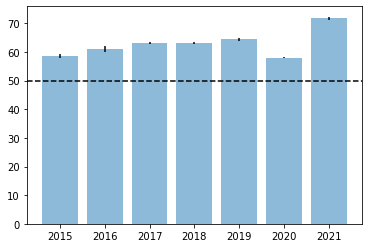

In [110]:
plt.bar(yearly_world[yearly_world.Date.dt.year > 2014].Date.dt.year, yearly_world[yearly_world.Date.dt.year > 2014].AQI, \
        alpha=0.5, yerr= yearly_world[yearly_world.Date.dt.year > 2014]['conf_interval_95%'])
plt.axhline(y=50, color='black', linestyle='--' )

The overall mean AQI in the world steadily rised from 2015. However, we can see a drop in 2020. Comparing the year 2019 to 2020 by a Welch t-test (assuming unequal variances):



In [187]:
mean_2019, std_2019 = yearly_world[yearly_world.Date.dt.year == 2019]['Mean_AQI'].values[0], yearly_world[yearly_world.Date.dt.year == 2019]['std_dev'].values[0]
mean_2020, std_2020 = yearly_world[yearly_world.Date.dt.year == 2020]['Mean_AQI'].values[0], yearly_world[yearly_world.Date.dt.year == 2020]['std_dev'].values[0]

statistic = mean_2019-mean_2020
n_2019 = yearly_world[yearly_world.Date.dt.year == 2019]['No_points'].values[0]
n_2020 = yearly_world[yearly_world.Date.dt.year == 2020]['No_points'].values[0]

std_statistic = np.sqrt(std_2019**2 + std_2020**2)
df_welch = (std_2019**2+std_2020**2)**2/(std_2019**2/(n_2019-1) + std_2020**2/(n_2020-1))




alpha= 0.95
error = stats.t.interval(df=df_welch, alpha=alpha)[1] * std_statistic
CI = np.array([statistic-error, statistic+error])
CI_percent = (CI/mean_2019)*100
CI_percent

array([ 8.98992737, 11.00301641])

There is a drop in the world AQI between 9 and 11%, within a 95% confidence interval. How is the monthly decrease?

In [130]:
def monthly_world_AQI(df):
    
    print('Calculating the worldwide overall mean AQI for each month')
    cou_df = monthly_country_AQI(df)
    
    '''fdh'''
    cou_df = monthly_country_AQI(df)
    
    final_df = pd.DataFrame()
    years = np.sort(cou_df.Date.dt.year.unique())
    for year in years:
        year_df = cou_df[cou_df.Date.dt.year == year]
        months = year_df.Date.dt.month.unique()
        for month in months:
            month_df = year_df[year_df.Date.dt.month == month]
           
                
            # Monthly mean of the AQI across all countries
            mean_monthly_AQI = month_df['AQI'].mean() 
                
            # Standard deviation of the mean yearly pollutant. Assuming i.i.d i.e Cov = 0
            std_dev_mean = np.sqrt((month_df.std_dev ** 2).sum())/month_df.shape[0] # Propagation of std. deviations for the mean
            no_points = month_df.shape[0]
                
            total_no_points = month_df.Total_no_points.sum()
            
            #T-test confidence interval calculation
            alpha= 0.95
            error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
            
            most_present_pollutant = month_df['Most_present_pollutant'].value_counts().index[0]
            
                
              
            date_string = '{}/{}'.format(year, month)
            temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y/%m'), 'Total_no_points': total_no_points, 'Most_present_pollutant': most_present_pollutant, \
                                            'No_points': no_points, 'AQI': [mean_monthly_AQI], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
            final_df = pd.concat([final_df, temp_df])    
                    
    return final_df.reset_index().drop('index', axis=1)
    

In [131]:
%%time
month_world_AQI_df = monthly_world_AQI(df)

Calculating the worldwide overall mean AQI for each month
Calculating the overall AQI for each month and country
Calculating the the AQI for each pollutant, month and country
Not_logical
Calculating the overall AQI for each month and country
Calculating the the AQI for each pollutant, month and country
Not_logical
Wall time: 2min 56s


In [190]:
month_world_AQI_df

,Date,Total_no_points,Most_present_pollutant,No_points,AQI,std_dev,conf_interval_95%
0,2014-12-01,5543,pm25,46,75.703095,1.743658,3.511907
1,2015-01-01,58095,pm25,48,65.742519,0.596284,1.199568
2,2015-03-01,62583,pm25,49,62.474411,0.485421,0.976005
3,2015-05-01,65746,pm25,56,53.002949,0.391870,0.785325
4,2015-02-01,56651,pm25,49,67.548685,0.552434,1.110743
5,2015-04-01,60646,pm25,55,54.926571,0.494754,0.991922
6,2015-06-01,63440,pm25,56,51.450082,0.404830,0.811297
7,2015-07-01,10359,pm25,56,55.042168,0.771545,1.546211
8,2015-12-01,6913,pm25,53,68.034169,1.910842,3.834384
9,2016-02-01,63416,pm25,58,56.741740,0.476171,0.953515


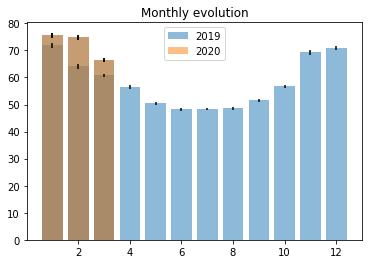

In [153]:
plt.bar(month_world_AQI_df[month_world_AQI_df.Date.dt.year > 2019].Date.dt.month, month_world_AQI_df[month_world_AQI_df.Date.dt.year > 2019].AQI, \
        alpha=0.5, yerr= month_world_AQI_df[month_world_AQI_df.Date.dt.year > 2019]['conf_interval_95%'], label='2019' )
plt.bar(month_world_AQI_df[month_world_AQI_df.Date.dt.year > 2020].Date.dt.month, month_world_AQI_df[month_world_AQI_df.Date.dt.year > 2020].AQI, \
        alpha=0.5, yerr= month_world_AQI_df[month_world_AQI_df.Date.dt.year > 2020]['conf_interval_95%'], label='2020' )
plt.title('Monthly evolution')
plt.legend()
#plt.axhline(y=50, color='black', linestyle='--' )

<AxesSubplot:xlabel='Date', ylabel='AQI'>

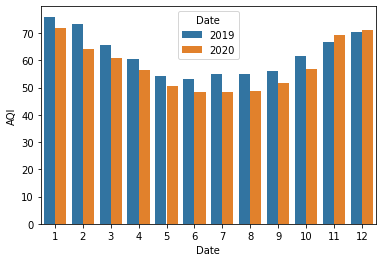

In [229]:
months = month_world_AQI_df[(month_world_AQI_df.Date.dt.year > 2018) & (month_world_AQI_df.Date.dt.year < 2021)].Date.dt.month
world_month_AQI_19_20 = month_world_AQI_df[(month_world_AQI_df.Date.dt.year > 2018) & (month_world_AQI_df.Date.dt.year < 2021)].AQI

sns.barplot(x=months, y=world_month_AQI_19_20, \
        alpha=1, hue=month_world_AQI_df[(month_world_AQI_df.Date.dt.year > 2018) & (month_world_AQI_df.Date.dt.year < 2021)].Date.dt.year)

In [230]:
def t_conf_interval(df_a, df_b, confidence_interval=0.95):
    '''This function calculates a confidence interval via a t-statistic. If the ratio between variances is larger than 2, then a 
    Welch t-test is performed. The statistic is taken as mean(df_a) - mean(df_b)
    INPUT: Dataframe with the mean values of the distributions we want to compare and the std_dev of those means'''
    final_df = pd.DataFrame()
    years = df_a.Date.dt.year.unique()
    for year in years:
        months = df_a[df_a.Date.dt.year == year].Date.dt.month.unique()
        for month in months:
            mean_a = df_a[df_a.Date.dt.month == month].AQI.values[0]
            mean_b = df_b[df_b.Date.dt.month == month].AQI.values[0]

            std_a = df_a[df_a.Date.dt.month == month].std_dev.values[0]
            std_b = df_b[df_b.Date.dt.month == month].std_dev.values[0]

            statistic = mean_a-mean_b

            n_a = df_a[df_a.Date.dt.month == month]['No_points'].values[0]
            n_b = df_b[df_b.Date.dt.month == month]['No_points'].values[0]

            std_statistic = np.sqrt(std_2019**2 + std_2020**2)
            if (std_a**2/std_b**2 > 2) or (std_a**2/std_b**2) < 0.5:
                #Apply Welch t-test method
                degrees_freedom = (std_a**2+std_b**2)**2/(std_a**2/(n_a-1) + std_a**2/(n_b-1))
            
            degrees_freedom = n_a + n_b - 2

            alpha= 0.95
            error = stats.t.interval(df=degrees_freedom, alpha=alpha)[1] * std_statistic
            CI = np.array([statistic, error])
            #Calculate percentage with respect to the previous year
            CI_percent = (CI/mean_2019)*100
            temp_df = pd.DataFrame({'Year':str(df_a.Date.dt.year.unique()[0])+'-'+str(df_b.Date.dt.year.unique()[0]) , 'Month': month, \
                                    'middle': CI_percent[0], 'std_95th': [CI_percent[1]]})
            final_df = pd.concat([final_df, temp_df])
            
    return final_df.reset_index().drop('index', axis=1).sort_values(by='Month')

In [231]:
df_month_2019 = month_world_AQI_df[(month_world_AQI_df.Date.dt.year == 2019)]
df_month_2020 = month_world_AQI_df[(month_world_AQI_df.Date.dt.year == 2020)]

# Confidence intervals for all months of both years:

df_conf = t_conf_interval(df_month_2020, df_month_2019)

In [232]:
df_conf

,Year,Month,middle,std_95th
0,2020-2019,1,-6.365575,0.832138
2,2020-2019,2,-14.185976,0.832024
1,2020-2019,3,-7.614742,0.831774
3,2020-2019,4,-6.027458,0.831774
4,2020-2019,5,-6.059493,0.831774
5,2020-2019,6,-7.495906,0.831673
6,2020-2019,7,-10.074782,0.831707
7,2020-2019,8,-9.871934,0.831707
8,2020-2019,9,-7.081576,0.831707
9,2020-2019,10,-7.596447,0.831707


In [233]:
def plot_with_err(x, data, **kwargs):
    y = data.middle
    lines = plt.plot(x, y, '-', **kwargs)
    middle = data.middle
    std = data.std_95th
    plt.fill_between(x, middle - std, middle + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)


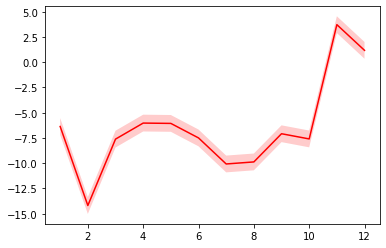

In [234]:

plot_with_err(df_conf.Month, df_conf, color='r')

In [602]:
lst = []
for year in np.sort(df.Date.dt.year.unique()):
    mean = df[df.Date.dt.year == year]['median'].mean()
    no_points = df[df.Date.dt.year == year].shape[0]
    std_dev_mean = np.std(df[df.Date.dt.year == year]['median'])/ np.sqrt(no_points)
    print(std_dev_mean)
    alpha= 0.95
    error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
    
   
    lst.append([mean, error_95th])
    

    
    

0.5189239729856939
0.054849983438597774
0.04741411361671712
0.05342758519917412
0.04843436730404274
0.030838763685589108
0.026797068457516303
0.07277840561752658


In [603]:
lst

[[27.602489626556107, 1.0172944725659379],
 [24.338431144039568, 0.10750433056419852],
 [22.992077628370012, 0.09293022651947212],
 [24.36007163354623, 0.10471645285409725],
 [23.811463769406586, 0.09492987956412523],
 [21.78719145408694, 0.06044294104408455],
 [20.870649898871008, 0.052521347812030016],
 [24.27049692067718, 0.14264378415038476]]

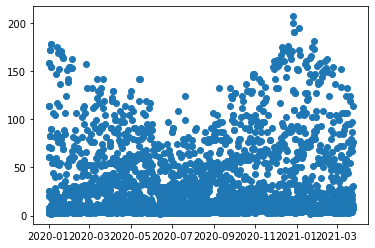

In [175]:
plt.scatter(df[(df.City == 'Wuhan') & (df.Date.dt.year > 2019)]['Date'], df[(df.City == 'Wuhan') & (df.Date.dt.year > 2019)]['median'])

In [139]:
d = calculate_mean_country(df[(df.Date.dt.year == 2016) & (df.Specie == 'no2')], countries = ['ES'], cities=True)
d

,Date,Country,City,Specie,Mean
0,2016-02-01,ES,Las Palmas de Gran Canaria,no2,3.251852
1,2016-03-01,ES,Las Palmas de Gran Canaria,no2,3.593548
2,2016-05-01,ES,Las Palmas de Gran Canaria,no2,3.248387
3,2016-06-01,ES,Las Palmas de Gran Canaria,no2,2.776667
4,2016-04-01,ES,Las Palmas de Gran Canaria,no2,3.520000
...,...,...,...,...,...
154,2016-03-01,ES,Oviedo,no2,6.993548
155,2016-06-01,ES,Oviedo,no2,4.676667
156,2016-01-01,ES,Oviedo,no2,9.866667
157,2016-07-01,ES,Oviedo,no2,4.133333


def calculate_mean_country(df, countries):
    '''This function calculates the monthly average of the pollutant aqi for the inserted countries and for all the available years in the dataset
    INPUT: 
    OUTPUT: '''
    final_df = pd.DataFrame()
    cities_country = df.City.unique()
    years = df.Date.dt.year.unique()
    months = df.Date.dt.month.unique()
    for country in countries:
        #print(country)
        for city in cities_country:
           # print(city)
            for year in years:
              #  print(year)
                for month in months:
                  #  print(month)
                    country_filter = df.Country == country
                    city_filter = df.City == city
                    year_filter = df.Date.dt.year == year
                    month_filter = df.Date.dt.month == month
                    
                    mean_ser = df[country_filter & city_filter & year_filter & month_filter]['median']
                    print(mean_ser)
                    date_string = '{}/{}'.format(year, month)
                    temp_df = pd.DataFrame(data={'Date':datetime.strptime(date_string, '%Y/%m'), 'Country': country, 'City': city, 'Mean': mean_ser})
                    
                    final_df = pd.concat([final_df, temp_df])
    return final_df
                    

In [473]:
def yearly_country_AQI(cou_df):
    '''The input for this function must be a dataframe with output from calculate_mean_country(cities=False)'''
    final_df = pd.DataFrame()
    final_df_2 = pd.DataFrame()
    years = np.sort(cou_df.Date.dt.year.unique())
    for year in years:
        year_df = cou_df[cou_df.Date.dt.year == year]
        countries = year_df.Country.unique()
        for country in countries:
            country_df = year_df[year_df.Country == country]
            pollutants = country_df.Specie.unique()
            
            # Calculation of the yearly mean for each pollutant:
          
            for pollutant in pollutants:
                pollutant_df = country_df[country_df.Specie == pollutant]
                
                # Yearly mean of the AQI for a particular pollutant and country
                mean_yearly_pollutant = pollutant_df['Mean'].mean() 
                
                
                # Standard deviation of the mean yearly pollutant
                std_dev_mean = np.sqrt((pollutant_df.std_dev ** 2).sum())/pollutant_df.shape[0]
                
                no_points = pollutant_df.No_points.sum()
        
                date_string = '{}'.format(year)
                temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), 'Country': country, \
                                            'No_points': no_points, 'Specie': pollutant, 'AQI': [mean_yearly_pollutant], 'std_dev': std_dev_mean})
                final_df = pd.concat([final_df, temp_df]) 
                final_df_2 = pd.concat([final_df_2, pollutant_df])
                    
    return final_df.reset_index().drop('index', axis=1), final_df_2

In [441]:
def yearly_world_AQI(yearly_cou_df):
    '''The input for this function must be a dataframe with output from calculate_mean_country(cities=False)'''
    final_df = pd.DataFrame()
    years = np.sort(yearly_cou_df.Date.dt.year.unique())
    for year in years:
        year_df = yearly_cou_df[yearly_cou_df.Date.dt.year == year]
        pollutants = year_df.Specie.unique()
        
        for pollutant in pollutants:
            pollutant_df = year_df[year_df.Specie == pollutant]
            # World mean AQI:
            mean_world_AQI = pollutant_df.AQI.mean()

            # Standard deviation:
            std_dev_mean = np.sqrt((pollutant_df.std_dev ** 2).sum())/pollutant_df.shape[0] 
            no_points = pollutant_df.No_points.sum()

            date_string = '{}'.format(year)
            temp_df = pd.DataFrame({'Date': datetime.strptime(date_string, '%Y'), \
                                    'No_points': no_points, 'Specie': pollutant, 'Mean_AQI': [mean_world_AQI], 'std_dev': std_dev_mean })
            final_df = pd.concat([final_df, temp_df])
    
    return final_df.reset_index().drop('index', axis=1)

In [761]:
def monthly_mean_country(df, countries, cities=False):
    '''This function calculates the monthly aqi average of all the pollutants present in the table for the inserted countries and for all the available years in the dataset.
    It also corrects the median values which are larger than 500 (following the US EPA standard, which ranges from 0-500)
    INPUT: df: pd.DataFrame with columns 'Date', 'Country', 'City', 'median'
            countries: list with the countries to be extracted
            cities: bool if False the output is a pd.DataFrame with the COUNTRY average AQI values per month. If True, the output is a pd.DataFrame with the CITIES AQI average per month
    OUTPUT: '''
    final_df = pd.DataFrame()
   
    pollutants = df.Specie.unique()
    for pollutant in pollutants:
        pollutant_df = df[df.Specie == pollutant]
        for country in countries:
            country_df = pollutant_df[pollutant_df.Country == country]
            years = country_df.Date.dt.year.unique()
            for year in years:
                year_df = country_df[country_df.Date.dt.year == year]
                
            if not cities:
                months = year_df.Date.dt.month.unique()
                for month in months:
                    #Dataframe with all cities for a given country
                    month_country_df = year_df[year_df.Date.dt.month == month]
                        
                    mean_ser = month_country_df['median'] 
                    date_string = '{}/{}'.format(year, month)
                        
                    #Standard deviation
                    std_dev = np.std(month_country_df['median'])
                    no_points = month_country_df.shape[0]
                        
                    std_dev_mean = std_dev/np.sqrt(no_points)
                        
                    ## T-test confidence interval
                    alpha= 0.95
                    error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
                    # Note: months that only have one measurement will be given a NaN value by the t-test and thus, won't be taken into account further
                        
                    temp_df = pd.DataFrame(data={'Date':datetime.strptime(date_string, '%Y/%m'), 'Country': country, 'No_points': no_points, 'Specie': pollutant, \
                                                     'Mean': [mean_ser.mean()], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})
             
                    #print(temp_df)
                    final_df = pd.concat([final_df, temp_df])
            
            if cities:
                cities_country = year_df.City.unique()
                for city in cities_country:
                    city_df = year_df[year_df.City == city]
                    months = city_df.Date.dt.month.unique()
                    for month in months:                        
                    #Dataframe with all cities for a given country
                        month_country_df = year_df[year_df.Date.dt.month == month]
                        
                        mean_ser = month_country_df['median'] 
                        date_string = '{}/{}'.format(year, month)
                        
                        #Standard deviation
                        std_dev = np.std(month_country_df['median'])
                        no_points = month_country_df.shape[0]

                        std_dev_mean = std_dev/np.sqrt(no_points)

                        ## T-test confidence interval
                        alpha= 0.95
                        error_95th = stats.t.interval(df=no_points-1, alpha=alpha)[1] * std_dev_mean
                        # Note: months that only have one measurement will be given a NaN value by the t-test and thus, won't be taken into account further

                        temp_df = pd.DataFrame(data={'Date':datetime.strptime(date_string, '%Y/%m'), 'Country': country, 'City': city, 'No_points': no_points, 'Specie': pollutant, \
                                                         'Mean': [mean_ser.mean()], 'std_dev': std_dev_mean, 'conf_interval_95%': error_95th})


                        final_df = pd.concat([final_df, temp_df])
    
                           
    return final_df.reset_index().drop('index', axis=1)

In [ ]:
pollutants = month_df.Specie.unique()
            
            # Calculation of the yearly mean for each pollutant:
            counter = 0
            pollutant_dict = {}
            std_dev_dict = {}
            conf_interval_dict = {}
            for pollutant in pollutants:
                pollutant_df = country_df[country_df.Specie == pollutant]
                
                # Monthly mean of the AQI for a particular pollutant and country
                pollutant_dict[pollutant] = pollutant_df['AQI'][0]
                
                # Standard deviation of the mean monthly pollutant. Assuming i.i.d, i.e Cov = 0
                std_dev_dict[pollutant] = pollutant_df['std_dev'][0]
                no_points = pollutant_df.No_points[0]
                
                total_no_points = pollutant_df.shape[0]
                conf_interval_dict[pollutant] = pollutant_df['conf_interval_95%'][0]
                
                counter += 1
                
                # Calculation of the overall AQI (max of the individual pollutant AQIs)
                if counter == len(pollutants):
                    overall_monthly_AQI = pollutant_dict[max(pollutant_dict, key=pollutant_dict.get)] #key attribute is needed. Otherwise it will return the (computationally) largest dict_key
                    std_dev_monthly_AQI = std_dev_dict[max(pollutant_dict, key=pollutant_dict.get)]
                    conf_interval_monthly_AQI = conf_interval_dict[max(conf_interval_dict, key=conf_interval_dict.get)]